In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (1234/1234), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 4056 (delta 1141), reused 1124 (delta 1124), pack-reused 2822
Receiving objects: 100% (4056/4056), 649.94 MiB | 15.91 MiB/s, done.
Resolving deltas: 100% (2386/2386), done.
Updating files: 100% (248/248), done.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

In [4]:
import os
import zipfile

from pathlib import Path

import requests

data_path = Path("/content/drive/MyDrive/ML-Project")
image_path = data_path / "project-dataset"

In [5]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('/content/drive/MyDrive/ML-Project/project-dataset/train'),
 PosixPath('/content/drive/MyDrive/ML-Project/project-dataset/test'))

## 2. Create Datasets and DataLoaders


### 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision` v0.13+ there is now support for automatic data transform creation based on the pretrained model weights you're using.

In [6]:
import torchvision
from urllib.request import urlopen
from PIL import Image
!pip install timm
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.4 MB/s eta 0:00:00


In [7]:
model = timm.create_model('maxxvit_rmlp_small_rw_256.sw_in1k', pretrained=True)
model = model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/264M [00:00<?, ?B/s]

In [8]:
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)
transforms

Compose(
    Resize(size=269, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(256, 256))
    ToTensor()
    Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
)

In [9]:
# Change the mean and std values in the Normalize transform
new_mean = [0.485, 0.456, 0.406]
new_std = [0.229, 0.224, 0.225]

transforms.transforms[-1].mean = new_mean
transforms.transforms[-1].std = new_std
transforms

Compose(
    Resize(size=269, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(256, 256))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [10]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78d9ebd930a0>,
 ['Control', 'Disease'])

## 3. Getting a pretrained model

### 3.1 Which pretrained model should you use?

### 3.2 Setting up a pretrained model

In [11]:
# from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
# from torchvision.models._api import WeightsEnum
# from torch.hub import load_state_dict_from_url

# def get_state_dict(self, *args, **kwargs):
#     kwargs.pop("check_hash")
#     return load_state_dict_from_url(self.url, *args, **kwargs)
# WeightsEnum.get_state_dict = get_state_dict

# efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
# model = efficientnet_b0(weights="DEFAULT").to(device)
# model

In [12]:
model.head

ClassifierHead(
  (global_pool): SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
  (drop): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=768, out_features=1000, bias=True)
  (flatten): Identity()
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [ ]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 256, 256), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
MaxxVit (MaxxVit)                                                 [1, 3, 256, 256]     [1, 1000]            --                   True
├─Stem (stem)                                                     [1, 3, 256, 256]     [1, 96, 128, 128]    --                   True
│    └─Conv2d (conv1)                                             [1, 3, 256, 256]     [1, 48, 128, 128]    1,296                True
│    └─LayerNormAct2d (norm1)                                     [1, 48, 128, 128]    [1, 48, 128, 128]    96                   True
│    │    └─Identity (drop)                                       [1, 48, 128, 128]    [1, 48, 128, 128]    --                   --
│    │    └─GELU (act)                                            [1, 48, 128, 128]    [1, 48, 128, 128]    --                   --
│    └─Conv2d (conv2)                                        

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model, typically you will "freeze" the base layers of a pretrained/foundation model and update the output layers to suit your own problem.

In [13]:
for param in model.stem.parameters():
    param.requires_grad = False

for param in model.stages.parameters():
    param.requires_grad = False

for param in model.norm.parameters():
    param.requires_grad = False

for param in model.head.parameters():
    param.requires_grad = False

In [14]:
len(class_names)

2

In [15]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.head.fc = nn.Linear(in_features=768, out_features=len(class_names))
for param in model.head.fc.parameters():
    param.requires_grad = True

In [16]:
summary(model=model,
        input_size=(1, 3, 256, 256), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
MaxxVit (MaxxVit)                                                 [1, 3, 256, 256]     [1, 2]               --                   Partial
├─Stem (stem)                                                     [1, 3, 256, 256]     [1, 96, 128, 128]    --                   False
│    └─Conv2d (conv1)                                             [1, 3, 256, 256]     [1, 48, 128, 128]    (1,296)              False
│    └─LayerNormAct2d (norm1)                                     [1, 48, 128, 128]    [1, 48, 128, 128]    96                   False
│    │    └─Identity (drop)                                       [1, 48, 128, 128]    [1, 48, 128, 128]    --                   --
│    │    └─GELU (act)                                            [1, 48, 128, 128]    [1, 48, 128, 128]    --                   --
│    └─Conv2d (conv2)                                  

In [17]:
model.to(device)

MaxxVit(
  (stem): Stem(
    (conv1): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm1): LayerNormAct2d(
      (48,), eps=1e-06, elementwise_affine=True
      (drop): Identity()
      (act): GELU()
    )
    (conv2): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (stages): Sequential(
    (0): MaxxVitStage(
      (blocks): Sequential(
        (0): MaxxVitBlock(
          (conv): ConvNeXtBlock(
            (shortcut): Downsample2d(
              (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
              (expand): Identity()
            )
            (down): Identity()
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), groups=96)
            (norm): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
            (mlp): ConvMlp(
              (fc1): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1))
              (norm): Identity()
              (act): GELU()
     

# Writing the training loops

In [18]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

In [19]:
from typing import Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    accumulated_y_pred = np.array([])
    accumulated_y_true = np.array([])

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

        accumulated_y_pred = np.concatenate((accumulated_y_pred, y_pred_class.cpu().numpy()))
        accumulated_y_true = np.concatenate((accumulated_y_true, y.cpu().numpy()))

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    train_precision = precision_score(accumulated_y_true, accumulated_y_pred, average='macro')
    train_recall = recall_score(accumulated_y_true, accumulated_y_pred, average='macro')
    train_f1 = f1_score(accumulated_y_true, accumulated_y_pred, average='macro')

    return train_loss, train_acc, train_precision, train_recall, train_f1

In [20]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    accumulated_y_pred = np.array([])
    accumulated_y_true = np.array([])

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

            accumulated_y_pred = np.concatenate((accumulated_y_pred, test_pred_labels.cpu().numpy()))
            accumulated_y_true = np.concatenate((accumulated_y_true, y.cpu().numpy()))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    test_precision = precision_score(accumulated_y_true, accumulated_y_pred, average='macro')
    test_recall = recall_score(accumulated_y_true, accumulated_y_pred, average='macro')
    test_f1 = f1_score(accumulated_y_true, accumulated_y_pred, average='macro')

    return test_loss, test_acc, test_precision, test_recall, test_f1

In [21]:
from typing import Dict, List

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = { "train_loss": [],
                "train_acc": [],
                "train_precision": [],
                "train_recall": [],
                "train_f1": []
    }


    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, train_precision, train_recall, train_f1 = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_precision"].append(train_precision)
        results["train_recall"].append(train_recall)
        results["train_f1"].append(train_f1)

    # Return the filled results at the end of the epochs
    return results

In [22]:
from matplotlib import pyplot as plt

def plot(x1, title=''):
    plt.plot(x1, label='train')
    # plt.plot(x2, label='test')
    plt.title(title)
    plt.legend()
    plt.show()

## 4. Train model

In [23]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=1,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/1 [00:00<?, ?it/s]

## 5. Evalaute model by plotting loss curves

In [ ]:
# try:
#   from helper_functions import plot_loss_curves
# except:
#   print(f"[INFO] Couldn't find helper_functions.py, downloading...")
#   with open("helper_functions.py", "wb") as f:
#     import requests
#     request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
#     f.write(request.content)
#   from helper_functions import plot_loss_curves

# # Plot the loss curves of our model
# plot_loss_curves(results)

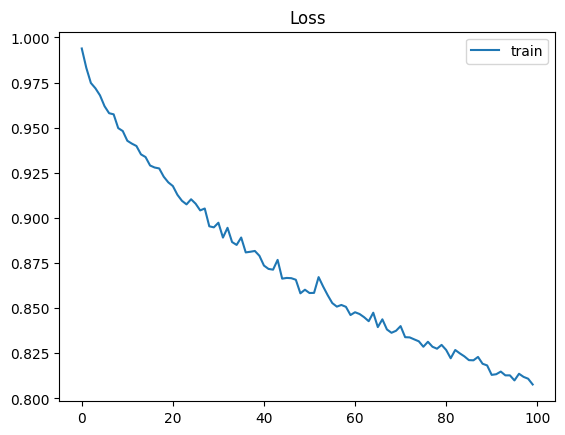

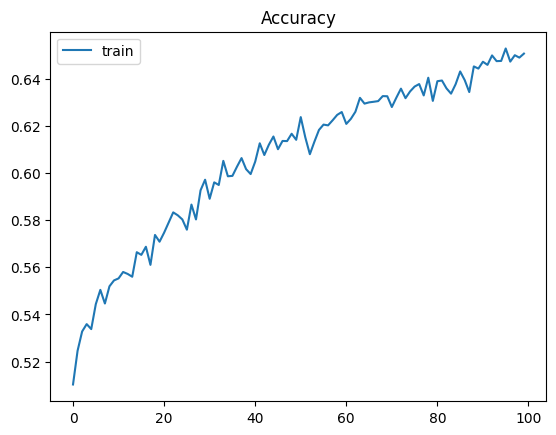

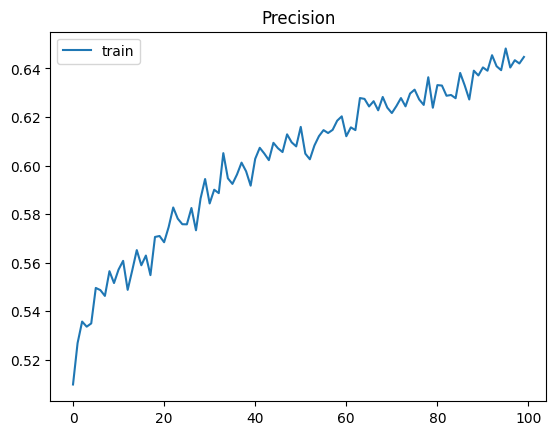

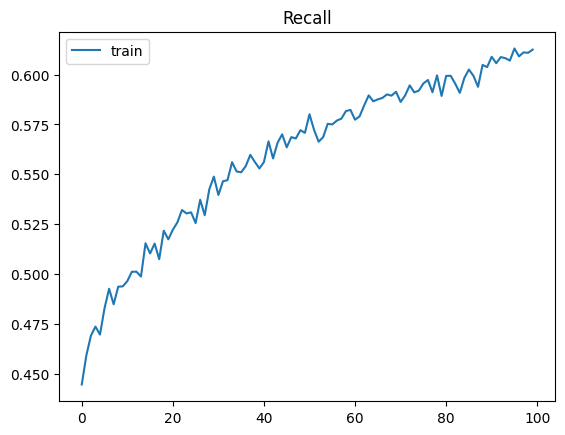

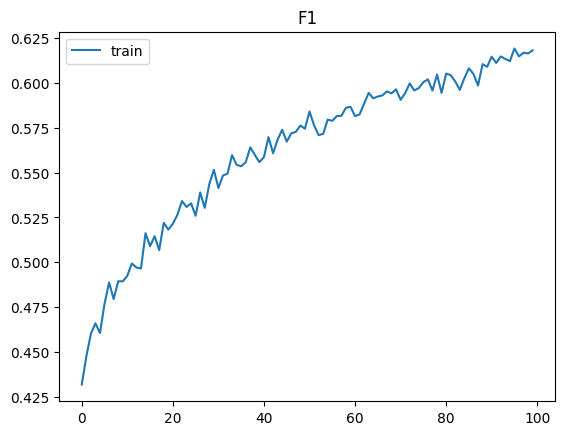

In [ ]:
plot(results['train_loss'], title='Loss')
plot(results['train_acc'], title='Accuracy')
plot(results['train_precision'], title='Precision')
plot(results['train_recall'], title='Recall')
plot(results['train_f1'], title='F1')

# Test

In [ ]:
test_loss, test_acc, test_precision, test_recall, test_f1 = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

print(f'Loss: {test_loss}')
print(f'Accuracy: {test_acc}')
print(f'Precision: {test_precision}')
print(f'Recall: {test_recall}')
print(f'F1: {test_f1}')

Loss: 0.9032673504617479
Accuracy: 0.5794444444444444
Precision: 0.5616556856866934
Recall: 0.544796730004419
F1: 0.545559081390463
